In [28]:
!pip install kikuchipy
!pip install import-ipynb

import import_ipynb
import impAt as at
import re
import torch 
import torch.utils.data as tor_utils
import os
import torch.nn as nn

import torchvision.models as torchmodels

import numpy as np

from fastai import *
from fastai.vision.all import *
from fastai.data.core import DataLoaders as fast_dataloaders
from orix.quaternion import Rotation, Symmetry
import kikuchipy as kp
import orix

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
import math

from fastai.losses import BaseLoss
import torch.nn.functional as F
from fastai.vision.all import *
from orix import sampling, plot, io
from orix.vector import Vector3d
import random
import cv2

In [29]:
#"""
realDataFileLoc = "/notebooks/DX54_biaxial_ref_small.h5"
mpFileLocs = ["/notebooks/ebsd_data/a.h5", "/notebooks/ebsd_data/f.h5"]
imgSize = int(576/ 4)

model = at.oneGreyResnet50
modelFileLoc = "S7"
model.final = torch.nn.Tanh

"""

realDataFileLoc = "/notebooks/ni/EDAX-Ni.h5"
mpFileLocs = ["/notebooks/ebsd_data/a.h5"]
imgSize = 60

model = at.DeepGreyResnet50
modelFileLoc = "N3"
"""

nMaterials = len(mpFileLocs)

if nMaterials > 1:
    arch = model(4 + nMaterials, 0, 0)  
else:
    arch = model(4, 0, 0)  
    
detector = kp.detectors.EBSDDetector(
        shape=(imgSize, imgSize),
        sample_tilt=70,
        pc=[0.421, 0.7794, 0.5049],
        convention="edax")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
learn = Learner([], arch, at.trueRotDistance)
learn.load(modelFileLoc)

In [31]:
data = kp.load(realDataFileLoc)
data.remove_dynamic_background()
data = data.data
print(data.shape)

data = (data - np.min(data)) / (np.max(data) - np.min(data))

a, b, x, y = data.shape
edges = int((y - x) / 2)
print(edges)
#ni_data = ni_data[:, :, :, edges: -edges]
a, b, x, y = data.shape
data = data.reshape((a * b, 1, x, y))

print(data.shape)

[########################################] | 100% Completed | 11.15 s
(48, 64, 576, 800)
112
(3072, 1, 576, 800)


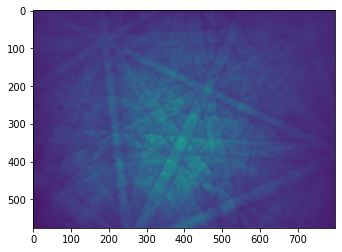

In [32]:
plt.imshow(data[0, 0, :, :])
plt.show()

(3072, 1, 576, 800)


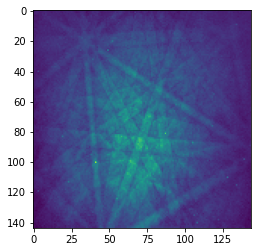

In [33]:
dataResized = np.zeros((a * b, imgSize, imgSize))

print(data.shape)
for i in range(a * b):
    dataResized[i] = cv2.resize(data[i, 0, :, :], (imgSize, imgSize), interpolation = cv2.INTER_LANCZOS4)


data = dataResized
#data = at.noiseReductionMedian(data, 3)
plt.imshow(data[0, :, :])
plt.show()

torch.Size([3072, 6])
torch.Size([48, 64, 2])


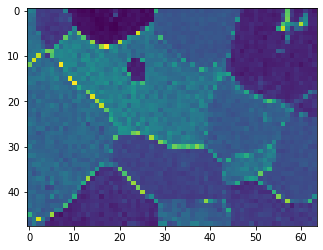

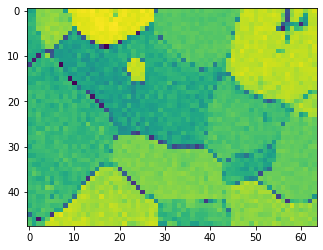

In [34]:
data = torch.tensor(data)
data = data.unsqueeze(1).float()

stdCrop = at.CircularCrop(radius = imgSize / 2, size = imgSize)
data = stdCrop(data).float()

learn.eval()
aiPred, _ = learn.get_preds(dl = [data.unsqueeze(0)])


print(aiPred.shape)


aiFlat = aiPred[:, :4]


if nMaterials > 1:
    aiPred = aiPred.reshape(a, b, 4 + nMaterials)
    materialTypes = aiPred[:, :, 4:]
    aiPred = aiPred[:, :, :4]
    print(materialTypes.shape)
    for i in range(nMaterials):
        materialType =  materialTypes[:, :, i]

        plt.imshow( materialType)
        plt.show()

    materialTypes = materialTypes.reshape(a * b, nMaterials)
    
else:
     aiPred = aiPred.reshape(a, b, 4)
                                          
                                          

In [35]:
examples = 30

x = [random.randint(0, a * b) for i in range(examples)]
#x = [i + 300 for i in range(examples)]


rots = aiFlat[x]
print(rots.shape)
rots = torch.nn.functional.normalize(rots)
rotations = Rotation(rots)

multImgs = torch.empty(0)

for fileLoc in mpFileLocs:
    mp = kp.load(fileLoc, projection="lambert")

    sim = mp.get_patterns(rotations = rotations,detector = detector, energy = 20, dtype_out = np.float32, compute = True)
    
    img = stdCrop(torch.tensor(sim.data).unsqueeze(1).half()).unsqueeze(0)
    multImgs = torch.cat([multImgs, img])
    
print(multImgs.shape)

torch.Size([30, 4])
[########################################] | 100% Completed | 101.81 ms
[########################################] | 100% Completed | 103.98 ms
torch.Size([2, 30, 1, 144, 144])



tensor([ 0.9102, -0.1857,  0.3475,  0.1278])


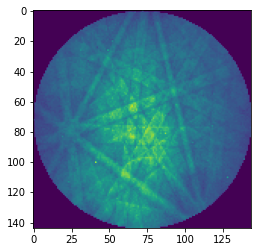

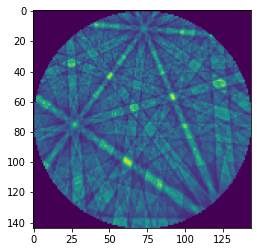


tensor([ 0.9285, -0.1746,  0.2774,  0.1745])


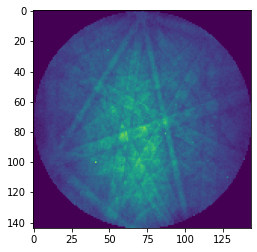

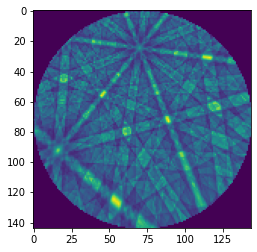


tensor([ 0.9110, -0.1994, -0.2722,  0.2372])


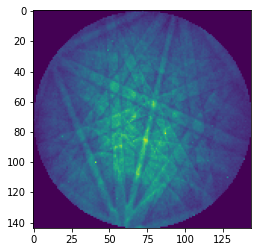

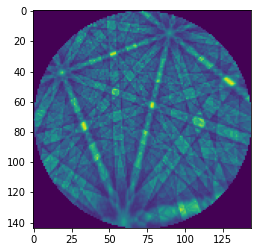


tensor([ 0.9276, -0.1662,  0.2841,  0.1769])


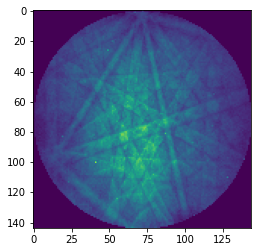

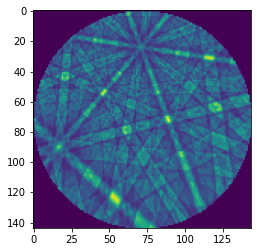


tensor([ 0.9158, -0.2346, -0.3234,  0.0397])


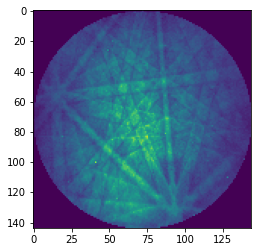

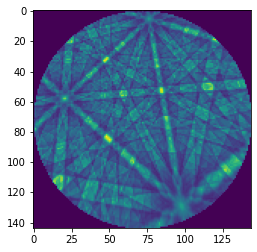


tensor([ 0.9113, -0.1970, -0.2723,  0.2376])


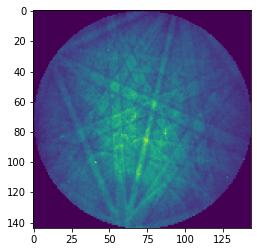

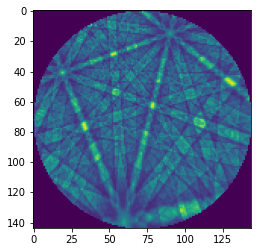


tensor([ 0.9168, -0.2330, -0.3214,  0.0441])


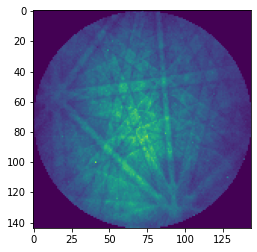

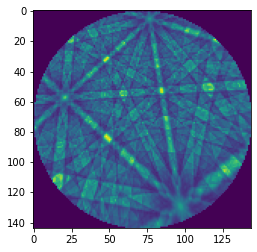


tensor([0.8902, 0.3417, 0.0755, 0.2918])


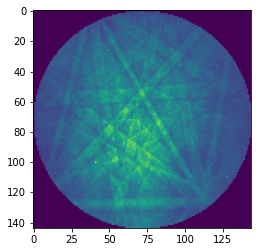

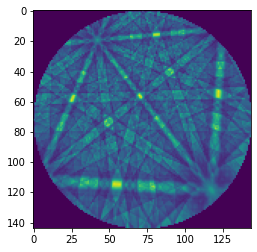


tensor([ 0.9278,  0.3011, -0.0184,  0.2194])


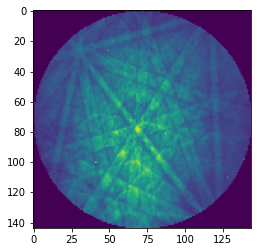

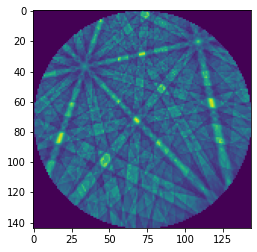


tensor([ 0.9114, -0.1836,  0.3464,  0.1253])


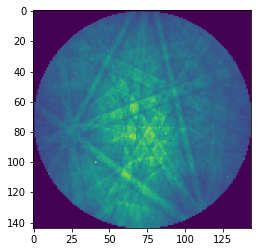

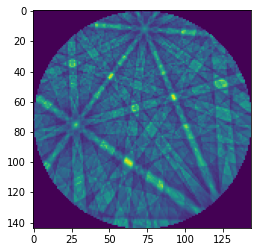


tensor([ 0.9392, -0.1941,  0.2789,  0.0498])


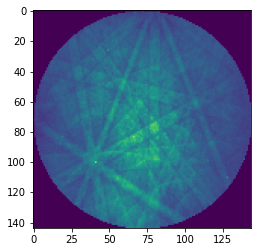

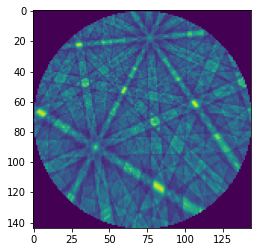


tensor([ 0.9550,  0.1106, -0.1696, -0.2168])


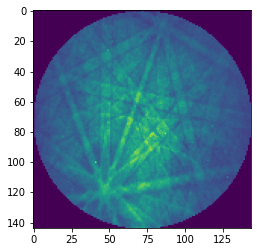

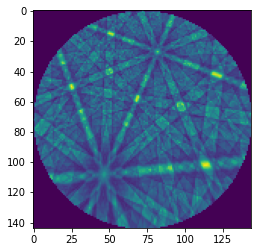


tensor([ 0.9268, -0.1692,  0.2847,  0.1774])


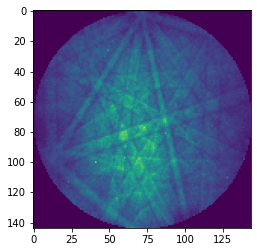

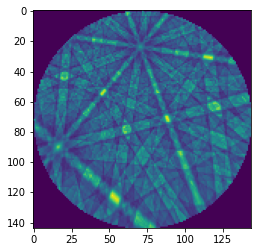


tensor([ 0.9269, -0.1721,  0.2832,  0.1762])


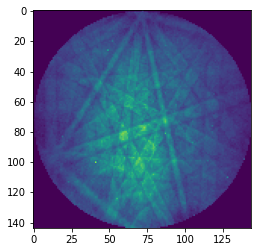

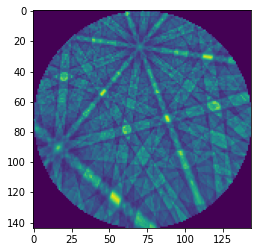


tensor([ 0.9171, -0.1270,  0.3479,  0.1475])


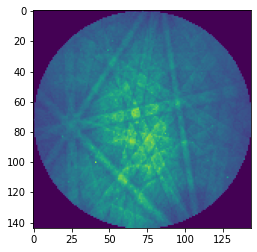

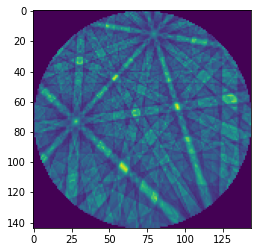


tensor([ 0.9172, -0.2308, -0.3220,  0.0424])


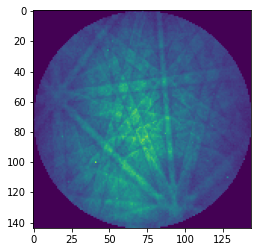

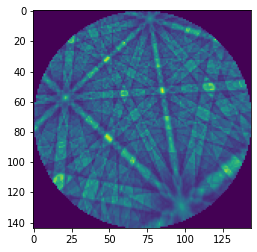


tensor([0.8900, 0.3403, 0.0756, 0.2939])


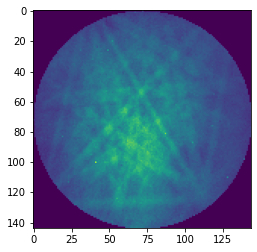

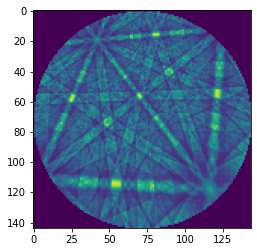


tensor([ 0.9867, -0.1566,  0.0122, -0.0428])


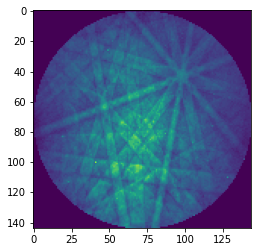

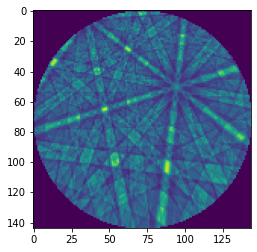


tensor([ 0.9169, -0.2334, -0.3208,  0.0438])


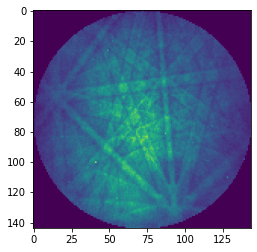

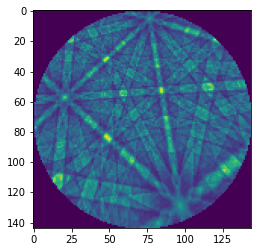


tensor([0.8907, 0.3420, 0.0750, 0.2900])


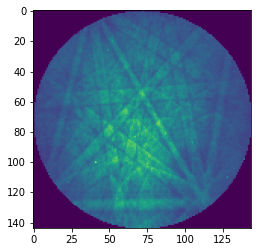

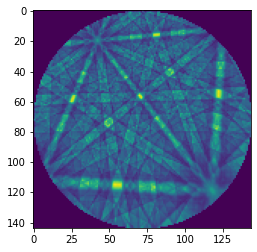


tensor([ 0.9112, -0.2002, -0.2715,  0.2365])


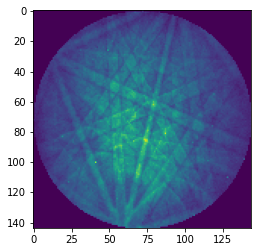

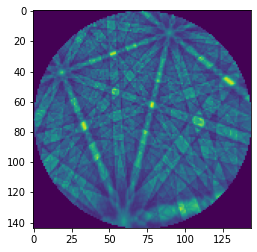


tensor([ 0.9121, -0.1832,  0.3444,  0.1258])


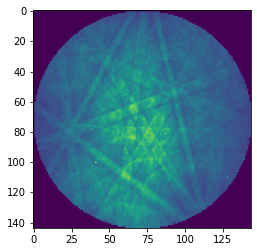

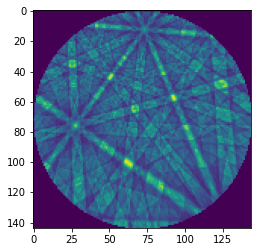


tensor([ 0.9277, -0.1702,  0.2811,  0.1773])


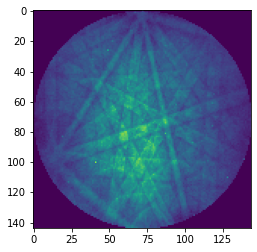

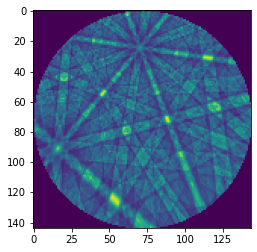


tensor([ 0.9108, -0.1990, -0.2723,  0.2380])


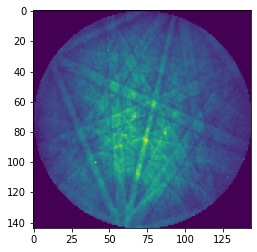

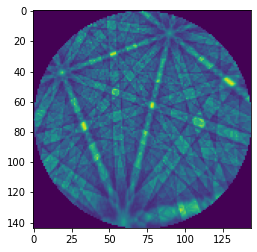


tensor([ 0.9502, -0.2565,  0.1354, -0.1140])


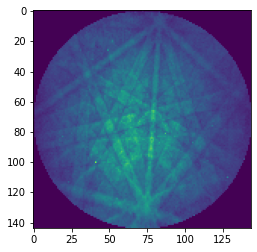

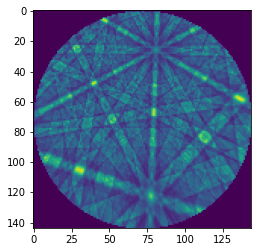


tensor([ 0.9272, -0.1657,  0.2850,  0.1777])


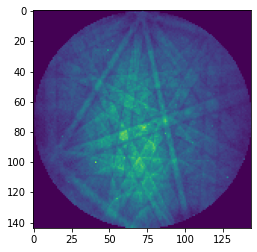

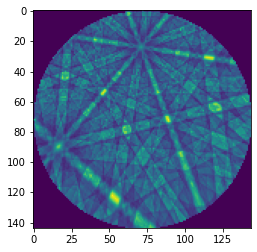


tensor([ 0.9190, -0.1473,  0.3257,  0.1660])


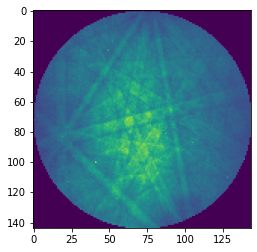

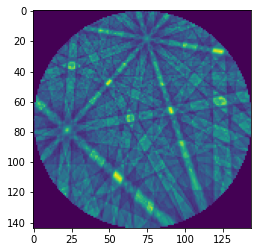


tensor([ 0.9393, -0.1934,  0.2792,  0.0487])


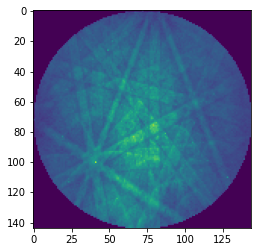

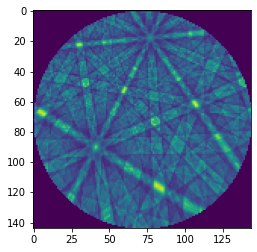


tensor([ 0.9387, -0.1947,  0.2805,  0.0481])


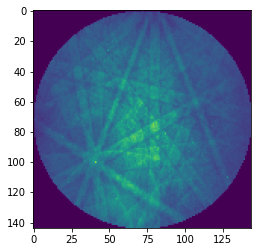

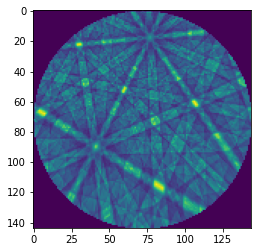


tensor([ 0.9183, -0.1520,  0.3274,  0.1625])


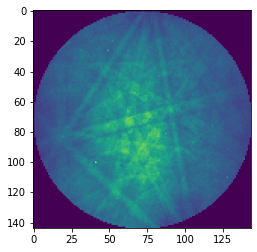

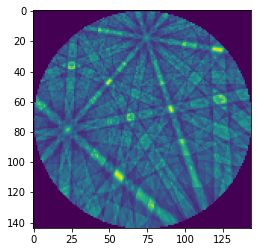

In [36]:
for i in range(examples):
    print()
    plt.imshow(data[x[i], 0, :, :])
    print(aiFlat[x[i]] / torch.norm(aiFlat[x[i]], dim = -1, keepdim = True))
    plt.show()

    loc = 0
    
    if nMaterials > 1:
        loc = torch.argmax(materialTypes[x[i]]).item()
    
    plt.imshow(multImgs[loc, i, 0])
    plt.show()

IPFColorKeyTSL, symmetry: m-3m, direction: [1 0 0]


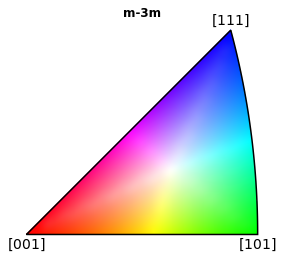

In [37]:
#aiPred = torch.nn.functional.normalize(aiPred)

mp = kp.load("/notebooks/ebsd_data/a.h5", projection="lambert")
pgm3m = mp.phase.point_group

ckey = plot.IPFColorKeyTSL(pgm3m, direction=Vector3d.xvector())
print(ckey)
ckey.plot()

torch.Size([48, 64, 4])


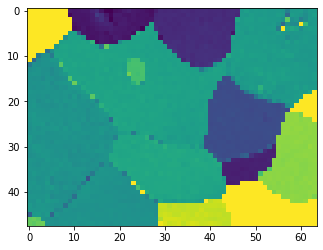

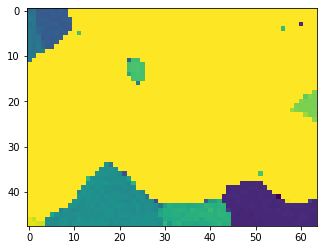

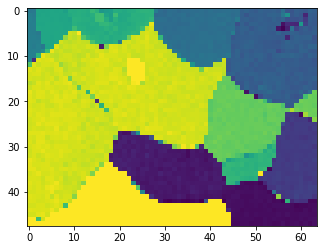

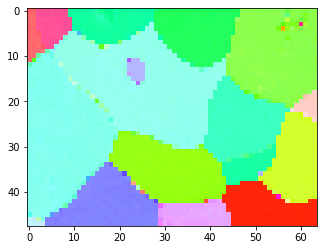

In [38]:

print(aiPred.shape)
aiRot = Rotation(aiPred)

rgb = ckey.orientation2color(aiRot)

for i in range(3):
    plt.imshow(rgb[:, :, i])
    plt.show()
    
    
plt.imshow(rgb)
plt.show()

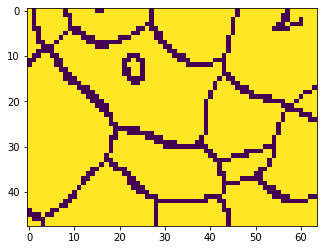

In [39]:
from scipy.ndimage import label

split = ~ at.grainSplit(aiPred, 0.05)

plt.imshow(split)
plt.show()

18
0.15732731842047096


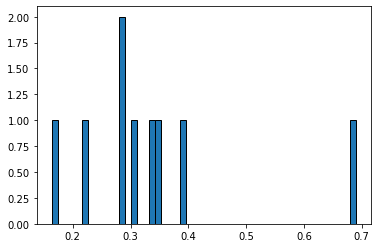

0.33721419201396174


In [40]:
labeledMap, numFeatures = label(split)
print(numFeatures)

rotDistance = at.avgRotDistance
misorientationList = []
sizeList = []
for i in range(numFeatures - 1):
    mask = labeledMap == i + 1
    grainOrientations = aiPred[mask]
    
    if grainOrientations.shape[0] > 10:

        grainOrientations = grainOrientations / torch.norm(grainOrientations, dim=-1, keepdim=True)
        avgGrain = at.averageQuaternions(grainOrientations)
        avgGrain = torch.tensor(avgGrain).unsqueeze(0)
        
        misorientation = rotDistance(avgGrain, grainOrientations)
        if misorientation > 2:
            #print(avgGrain)
            #print(grainOrientations)
            #print(misorientation)
            plt.imshow(mask)
            plt.show()
            
        misorientationList.append(misorientation)
        sizeList.append(grainOrientations.shape[0])
            
print(np.nansum(np.array(sizeList) * np.array(misorientationList)) / np.nansum(sizeList))

plt.hist(misorientationList, bins = 50, edgecolor='black')
plt.show()
print(np.nanmean(misorientationList))

tensor(0.3357)


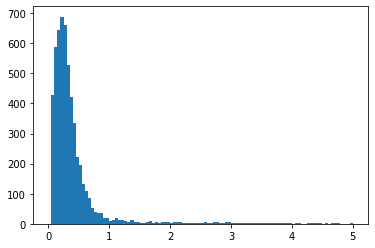

In [41]:
def trueRotDistance(q1, q2):

    q1_norm = q1 / torch.norm(q1, dim=-1, keepdim=True)
    q2_norm = q2 / torch.norm(q2, dim=-1, keepdim=True)

    # Compute the dot product between the normalized quaternions
    dot_product = torch.sum(q1_norm.unsqueeze(0) * q2_norm, dim=-1)
    
    # Clamp the dot product to ensure it is in the valid range [-1, 1]
    dot_product = torch.clamp(dot_product, -1.0 + 1e-7, 1.0 - 1e-7)

    # Compute the geodesic distance between the quaternions
    distance = torch.acos(dot_product) * 360 / 3.14159
    return torch.mean(distance)

def averageRotationDistance(ebsdMap, thresh = 2):
    total_distance = 0.0
    count = 0
    rows, cols, _ = ebsdMap.shape
    distanceList = []
    for i in range(rows):
        
        for j in range(cols):
            hasNan = torch.isnan(ebsdMap[i, j])
            if not torch.any(hasNan):
                
                if i < rows - 1:
                    hasNan = torch.isnan(ebsdMap[i+1, j])
                    if not torch.any(hasNan):
                        distance = trueRotDistance(ebsdMap[i, j], ebsdMap[i+1, j])
                        distanceList.append(distance)
                        if distance < thresh:
                            total_distance += distance
                            count += 1

                if j < cols - 1:
                    hasNan = torch.isnan(ebsdMap[i, j+1])
                    if not torch.any(hasNan):
                        distance = trueRotDistance(ebsdMap[i, j], ebsdMap[i, j+1])
                        distanceList.append(distance)
                        if distance < thresh:
                            total_distance += distance
                            count += 1

    if count == 0:
        count = 1
    return total_distance / count, distanceList

avgDistance, distanceList = averageRotationDistance(aiPred)
print(avgDistance)
plt.hist(distanceList, bins = 100, range = (0, 5))
plt.show()

18
There are 0 NaN values in the tensor.


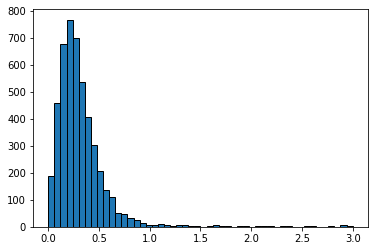

0.32867575


In [42]:
labeledMap, numFeatures = label(split)
print(numFeatures)
#plt.imshow(labeled_map)
#plt.show()

totalDistanceList = []


rot_distance = trueRotDistance
totalDistanceList = []
for i in range(numFeatures - 1):
    
    mask = labeledMap == i + 1
    grain0rientations = aiPred * np.expand_dims(mask, axis = -1)
    grainSize = grain0rientations.shape[0] * grain0rientations.shape[1]
    
    if grainSize > 10:
        grain0rientations = grain0rientations / torch.norm(grain0rientations, dim=-1, keepdim=True)
        misorientation, distanceList = averageRotationDistance(grain0rientations, 1e3)
        if misorientation > 2:
            plt.imshow(mask)
            plt.show()
        
        else:   
            totalDistanceList += distanceList
            
distances = torch.tensor(totalDistanceList)
nan_count = torch.sum(torch.isnan(distances)).item()

print(f"There are {nan_count} NaN values in the tensor.")

plt.hist(totalDistanceList, bins = 50, range = (0, 3), edgecolor='black')
plt.show()
print(np.mean(totalDistanceList))